# Random Forest

In [11]:
# Importing modules
import pandas as pd
import numpy as np
%matplotlib inline

# Load the cleaned data with DEP_DELAY included
df_cleaned = pd.read_csv("../cleaning-preprocessing/cleaned_flight_data_with_target.csv")

#Separating Features
X = df_cleaned.drop(columns=['DEP_DELAY'])  
y = df_cleaned['DEP_DELAY']

In [12]:
from sklearn.model_selection import train_test_split

# 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training size: {X_train.shape}")
print(f"Testing size: {X_test.shape}")

Training size: (23056, 110)
Testing size: (5764, 110)


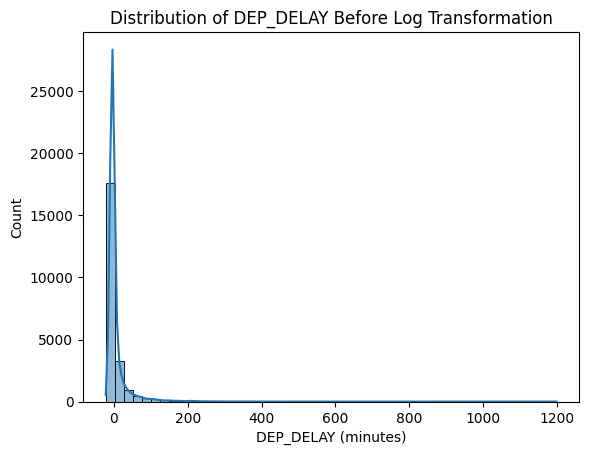

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Plot histogram of the target variable
sns.histplot(y_train, bins=50, kde=True)
plt.title("Distribution of DEP_DELAY Before Log Transformation")
plt.xlabel("DEP_DELAY (minutes)")
plt.show()

In [14]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Apply log transformation
y_train_log = np.log1p(y_train)  # log(1 + y) to avoid log(0)
y_test_log = np.log1p(y_test)

# Train the model again using the log-transformed target
clf = RandomForestRegressor(random_state=156)
clf.fit(X_train, y_train_log)
y_test_pred_log = clf.predict(X_test)

# Reverse log transformation for MSE comparison
y_test_pred = np.expm1(y_test_pred_log)

print("MSE after log transformation:", mean_squared_error(y_test, y_test_pred))
print("R² after log transformation:", r2_score(y_test, y_test_pred))

C:\Users\Cole\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Cole\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: Input y contains NaN.

In [ ]:
import pandas as pd

# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance.head(10))  # Display top 10 important features

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

top_features = feature_importance['Feature'].head(5)  # Select top 5 important features

for feature in top_features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=X_train[feature], y=y_train_log, alpha=0.5)
    plt.title(f"Relationship between {feature} and Log(DEP_DELAY)")
    plt.xlabel(feature)
    plt.ylabel("Log(DEP_DELAY)")
    plt.show()

In [ ]:
# Drop features with low importance (adjust threshold as needed)
low_importance_features = feature_importance[feature_importance["Importance"] < 0.002]["Feature"]
X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = X_test.drop(columns=low_importance_features)

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': np.arange(5, 30, 5),
    'n_estimators': np.arange(50, 210, 50),
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],    
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=156),
    param_grid=params,
    cv=5,
    n_jobs=-1,
    scoring='r2',
    verbose=1,
    return_train_score=True
)

grid_search.fit(X_train_reduced, y_train_log)

print("Best parameters:", grid_search.best_params_)

NameError: name 'X_train_reduced' is not defined

In [ ]:
# Train model with best parameters
clf_best = RandomForestRegressor(
    random_state=156,
    max_depth=grid_search.best_params_['max_depth'],
    n_estimators=grid_search.best_params_['n_estimators'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
    max_features=grid_search.best_params_['max_features']
)

clf_best.fit(X_train_reduced, y_train_log)
y_test_pred_log_final = clf_best.predict(X_test_reduced)

# Reverse log transformation for final evaluation
y_test_pred_final = np.expm1(y_test_pred_log_final)

print("Final MSE:", mean_squared_error(y_test, y_test_pred_final))
print("Final R²:", r2_score(y_test, y_test_pred_final))

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error, r2_score

# model_rf = RandomForestRegressor (n_estimators=100, random_state=156, max_features=30)

# model_rf.fit(X_train, y_train)
# preds_test = model_rf.predict(X_test)

# print('Random forest yields MSE and R-squared:', mean_squared_error(y_test, preds_test), r2_score(y_test, preds_test))

Random forest yields MSE and R-squared: 977.7937434594031 0.3292969086957185


## Hyperparameter Tuning

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error, r2_score

# clf = RandomForestRegressor(random_state=156)

# params = {
#     'max_depth': np.arange(5,30,5),
#     'n_estimators': np.arange(50,210,50)
# }

# grid_search = GridSearchCV(estimator=clf, param_grid=params, cv=5, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error', return_train_score=True)
# grid_search.fit(X_train, y_train)

# # Get the best estimator and show parameters

# grid_search.best_params_

# # Evaluate the tuned model

# clf_best = grid_search.best_estimator_
# y_test_pred = clf_best.predict(X_test)

# print('Hyperparameter tuning of random forest yields MSE and R-squared:', mean_squared_error(y_test, y_test_pred), r2_score(y_test, y_test_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Hyperparameter tuning of random forest yields MSE and R-squared: 921.8627697380753 0.36766192915681606


In [ ]:
# import pandas as pd

# # Get feature importances
# feature_importance = pd.DataFrame({
#     'Feature': X_train.columns,
#     'Importance': clf_best.feature_importances_
# }).sort_values(by='Importance', ascending=False)

# print("Feature importance prior to RFE",feature_importance.head(20))  # Check the top 20 most important features

Feature importance prior to RFE                              Feature  Importance
5                          CRS_DEP_M    0.176771
13                           sch_dep    0.165778
3                   CRS_ELAPSED_TIME    0.062854
6                          CRS_ARR_M    0.060337
12                          Pressure    0.055848
7                        Temperature    0.049755
2                        DAY_OF_WEEK    0.044640
1                       DAY_OF_MONTH    0.042161
8                          Dew Point    0.041161
9                           Humidity    0.036445
10                        Wind Speed    0.035312
0                              MONTH    0.013265
4                           DISTANCE    0.013163
11                         Wind Gust    0.011844
104  Condition_Partly Cloudy / Windy    0.011337
101          Condition_Mostly Cloudy    0.009618
64                          DEST_PIT    0.007657
86          Condition_Cloudy / Windy    0.007497
30                          DEST_BWI 

In [ ]:
# from sklearn.feature_selection import RFE

# # Instantiate the model again
# clf = RandomForestRegressor(random_state=156, n_estimators=grid_search.best_params_['n_estimators'], 
#                             max_depth=grid_search.best_params_['max_depth'])

# # Use RFE to select the top k features
# rfe = RFE(estimator=clf, n_features_to_select=15, step=1)  # Adjust n_features_to_select as needed
# rfe.fit(X_train, y_train)

# # Transform dataset to keep only selected features
# X_train_rfe = X_train.loc[:, rfe.support_]
# X_test_rfe = X_test.loc[:, rfe.support_]

# # Retrain the model using selected features
# clf.fit(X_train_rfe, y_train)
# y_test_pred_rfe = clf.predict(X_test_rfe)

# # Evaluate new model
# print("MSE after RFE:", mean_squared_error(y_test, y_test_pred_rfe))
# print("R² after RFE:", r2_score(y_test, y_test_pred_rfe)) GOT MSE 805, R^2 0.447

MSE after RFE: 805.1107287894159
R² after RFE: 0.4477462570676348
